In [ ]:
import pickle
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.utils import shuffle
import matplotlib.pyplot as pyplot
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_squared_error, r2_score

In [ ]:
def load_data_nutrition(
                    data_path = "data/nutrition/dog_nutrition_dataset.csv",
                    dog_breeds = [
                                'German Shepherd', 'Labrador', 'Pomeranian', 'Rottweiler',
                                'Mutt (Mixed Breed)', 'Golden Retriever', 'Doberman', 'Boxer', 'Dalmatian',
                                'Rhodesian Ridgeback'
                                ],
                    dog_diseases = ['obesity', 'digestive issues', 'healthy', 'diabetes', 'arthritis', 'kidney disease']
                    ):
    df = pd.read_csv(data_path)
    df['Breed'] = df['Breed'].apply(lambda x: dog_breeds.index(x))
    df['Disease'] = df['Disease'].apply(lambda x: dog_diseases.index(x))
    del df['Breed Code']
    
    X = df[['Breed', 'Age (months)', 'Weight (kg)', 'Disease']]
    Y = df.drop(['Breed', 'Age (months)', 'Weight (kg)', 'Disease'], axis=1)

    return X, Y

In [ ]:
X, Y = load_data_nutrition()
print(f"X Shape: {X.shape}")
print(f"Y Shape: {Y.shape}")

X Shape: (500, 4)
Y Shape: (500, 6)


In [ ]:
cat = CatBoostRegressor(
                        iterations=1000, 
                        learning_rate=0.1, 
                        depth=10
                        )
mm_cat = MultiOutputRegressor(cat)
mm_cat.fit(X, Y)

0:	learn: 2.4449921	total: 148ms	remaining: 2m 27s
1:	learn: 2.2931856	total: 149ms	remaining: 1m 14s
2:	learn: 2.1837464	total: 178ms	remaining: 59.1s
3:	learn: 2.0856967	total: 185ms	remaining: 46.2s
4:	learn: 2.0068278	total: 204ms	remaining: 40.6s
5:	learn: 1.9309341	total: 234ms	remaining: 38.8s
6:	learn: 1.8474100	total: 236ms	remaining: 33.5s
7:	learn: 1.7687541	total: 237ms	remaining: 29.3s
8:	learn: 1.7037965	total: 262ms	remaining: 28.9s
9:	learn: 1.6506434	total: 278ms	remaining: 27.5s
10:	learn: 1.6055671	total: 307ms	remaining: 27.6s
11:	learn: 1.5549660	total: 311ms	remaining: 25.6s
12:	learn: 1.5137307	total: 341ms	remaining: 25.9s
13:	learn: 1.4774709	total: 351ms	remaining: 24.7s
14:	learn: 1.4443763	total: 352ms	remaining: 23.1s
15:	learn: 1.4160733	total: 353ms	remaining: 21.7s
16:	learn: 1.3904777	total: 385ms	remaining: 22.3s
17:	learn: 1.3671886	total: 424ms	remaining: 23.1s
18:	learn: 1.3433990	total: 462ms	remaining: 23.9s
19:	learn: 1.3208375	total: 498ms	remai

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x000001AA9F142A40>)

In [ ]:
with open('artifacts/nutrition_model.pkl', 'wb') as f:
    pickle.dump(mm_cat, f)

### evaluation

In [ ]:
P = mm_cat.predict(X)

print(f"Mean Absolute Error: {mean_squared_error(Y, P)}")
print(f"Mean Squared Error: {mean_squared_error(Y, P)}")
print(f"R2 Score: {r2_score(Y, P)}")

Mean Absolute Error: 0.014847669641189762
Mean Squared Error: 0.014847669641189762
R2 Score: 0.9996200045524986


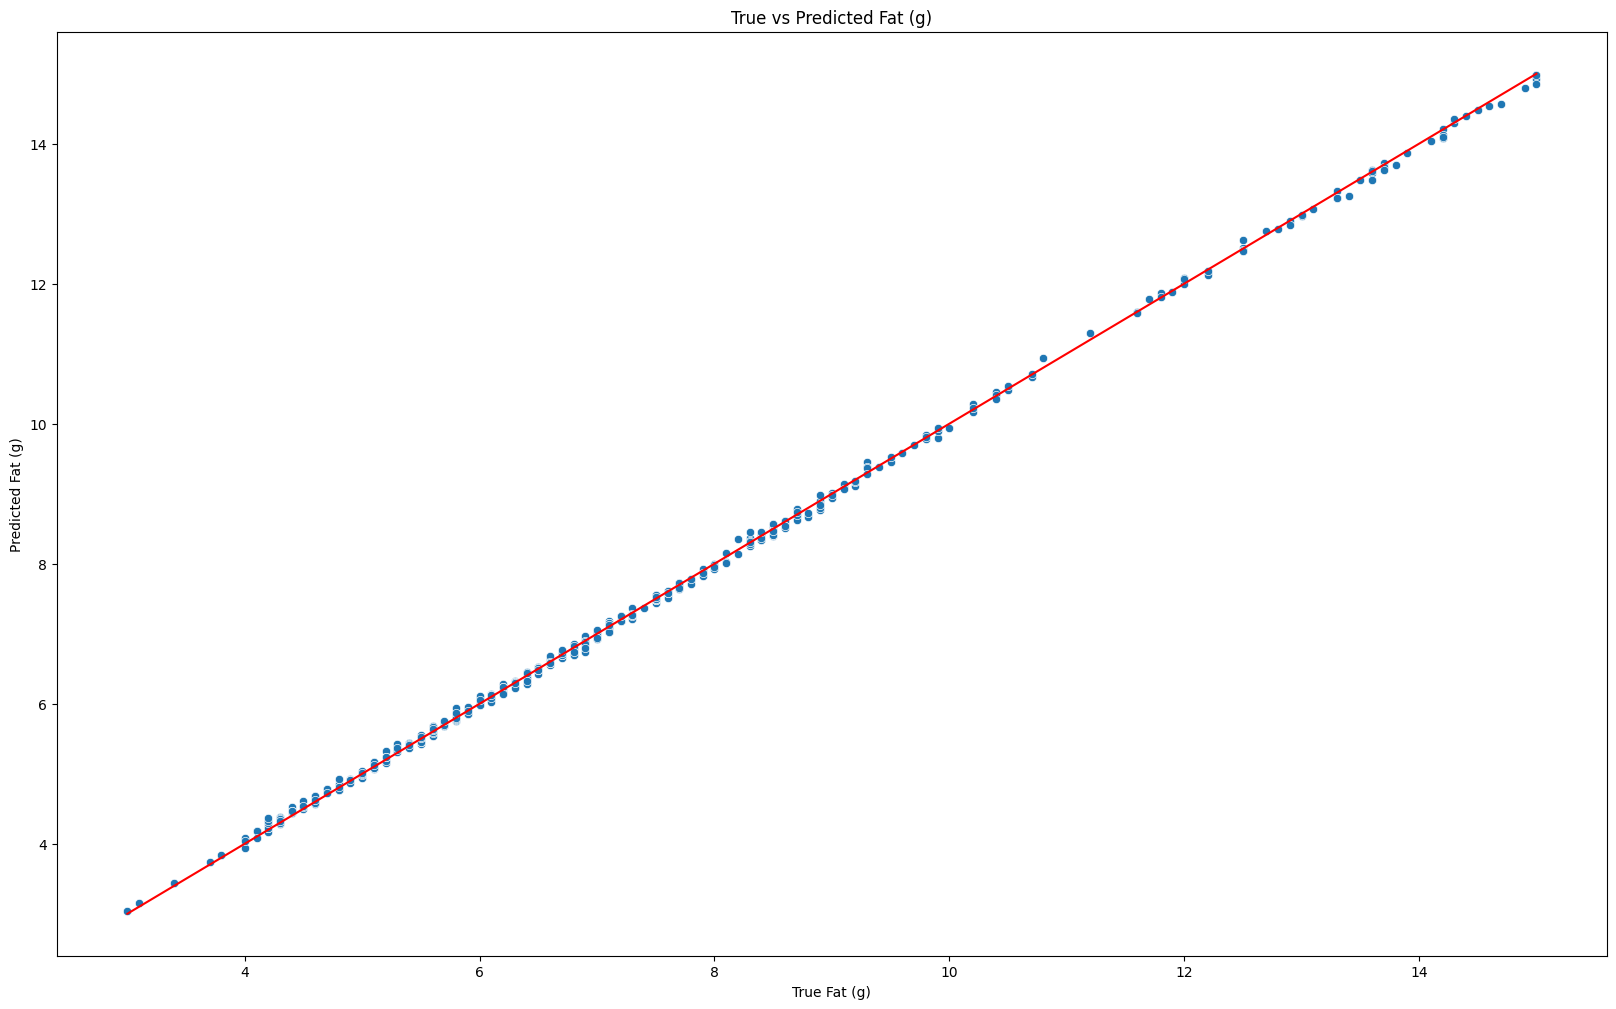

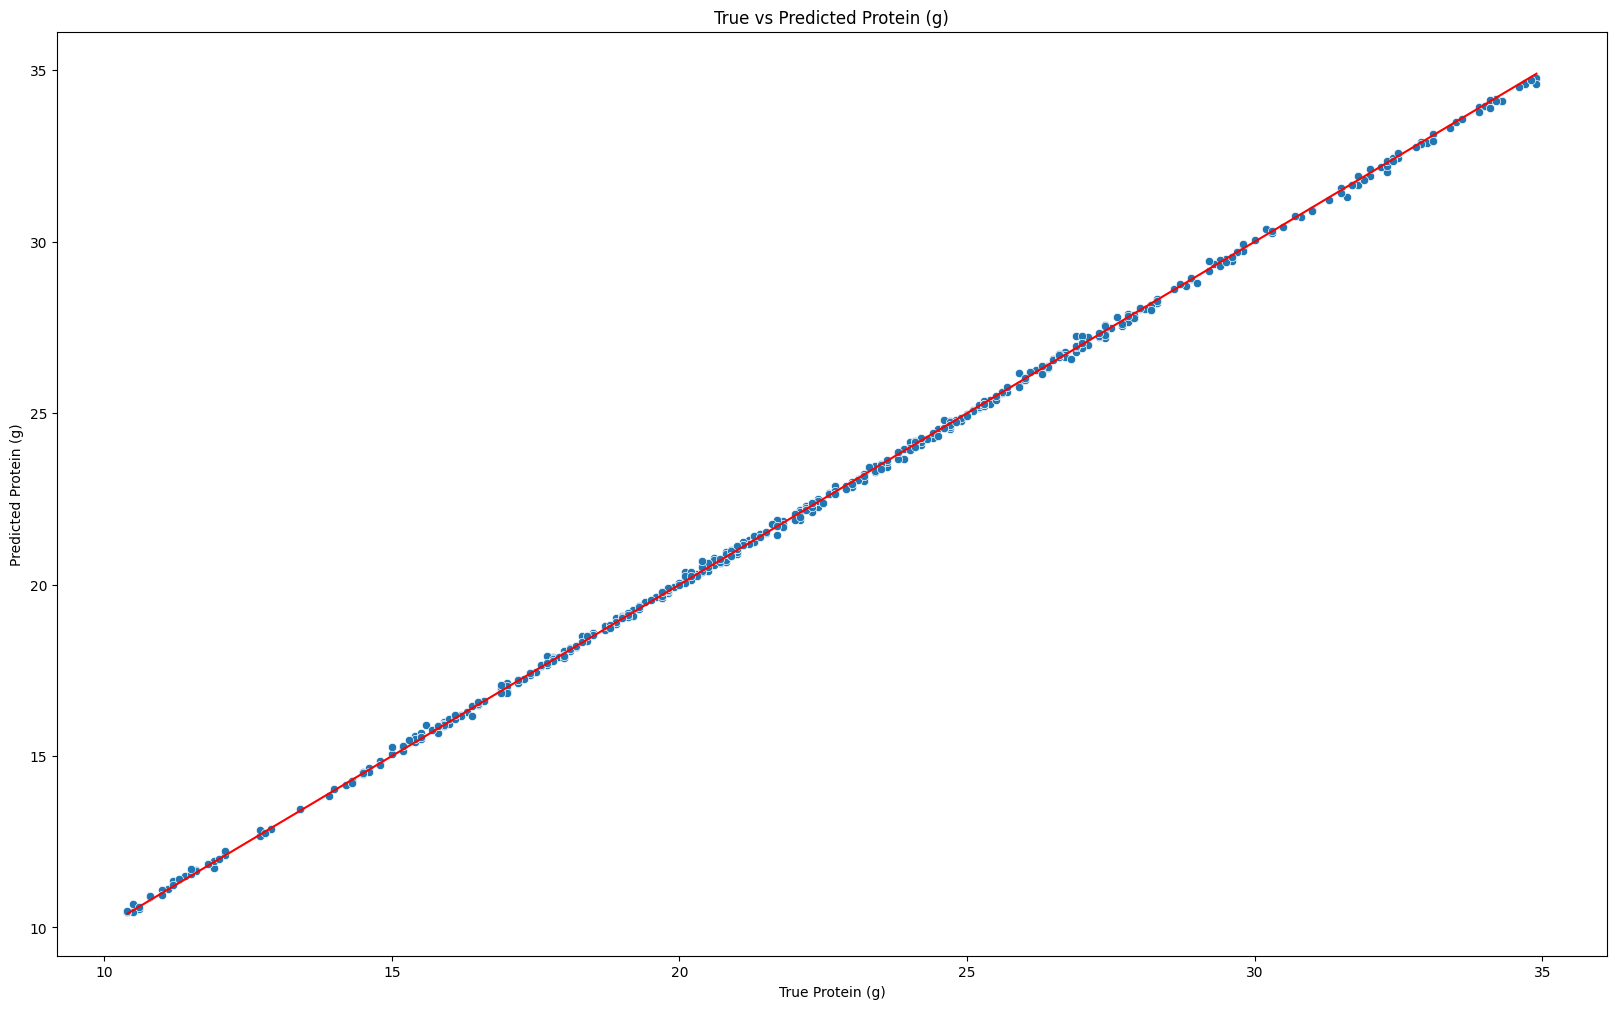

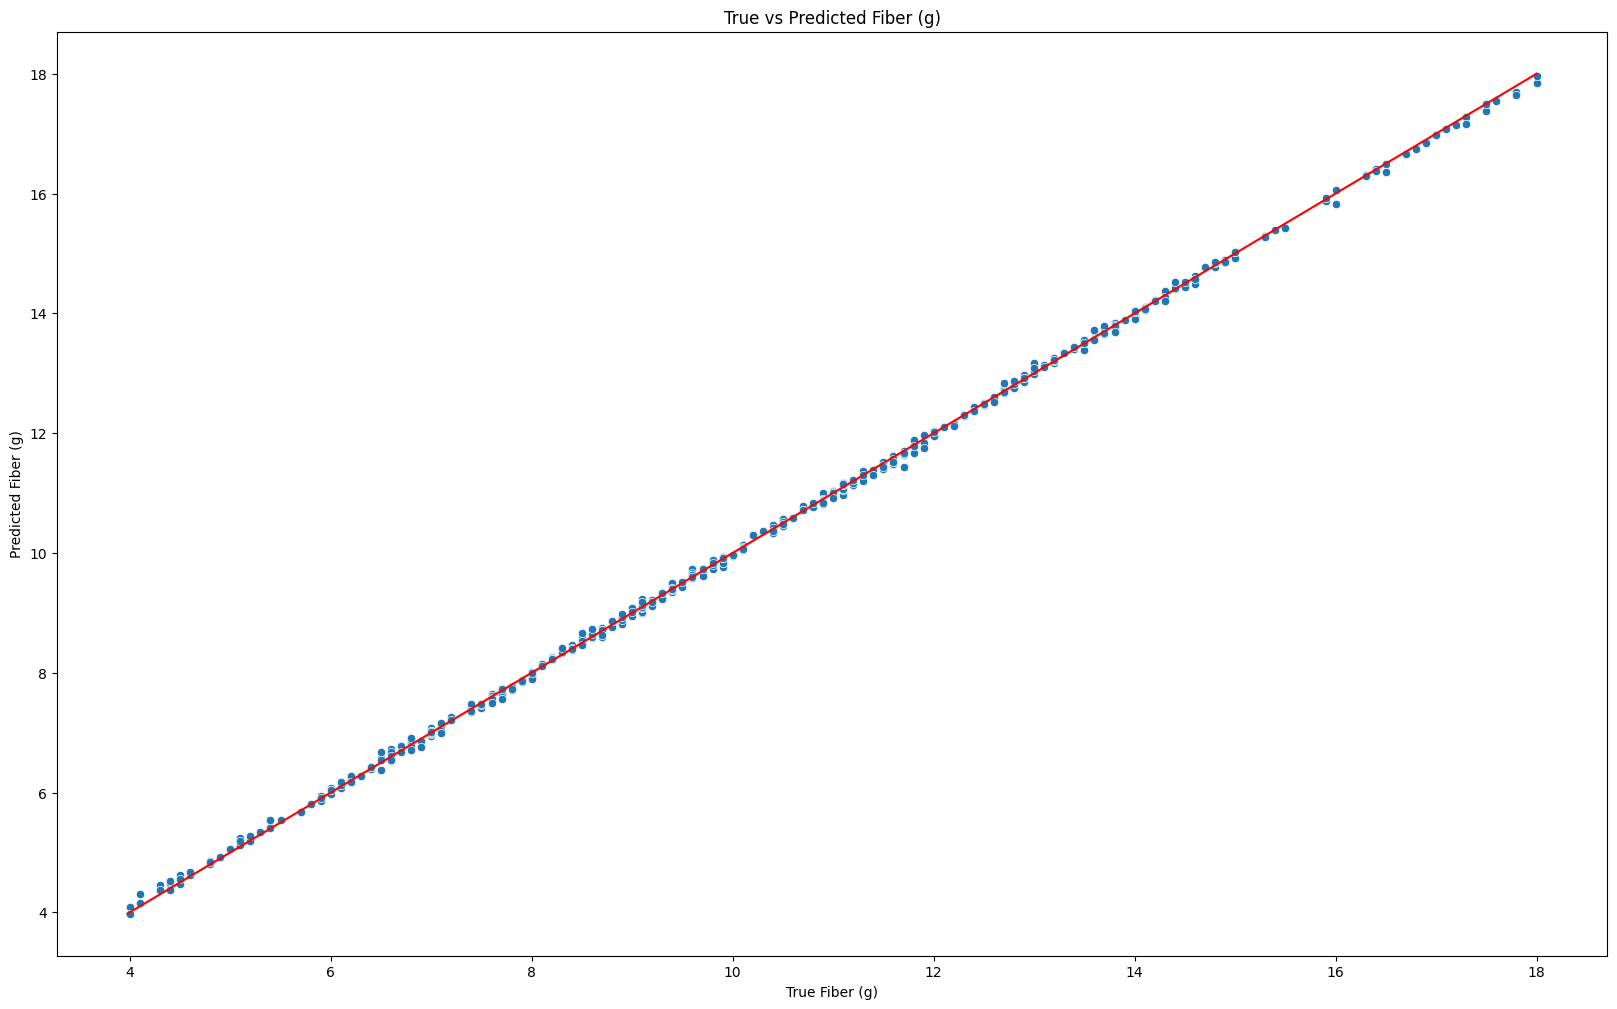

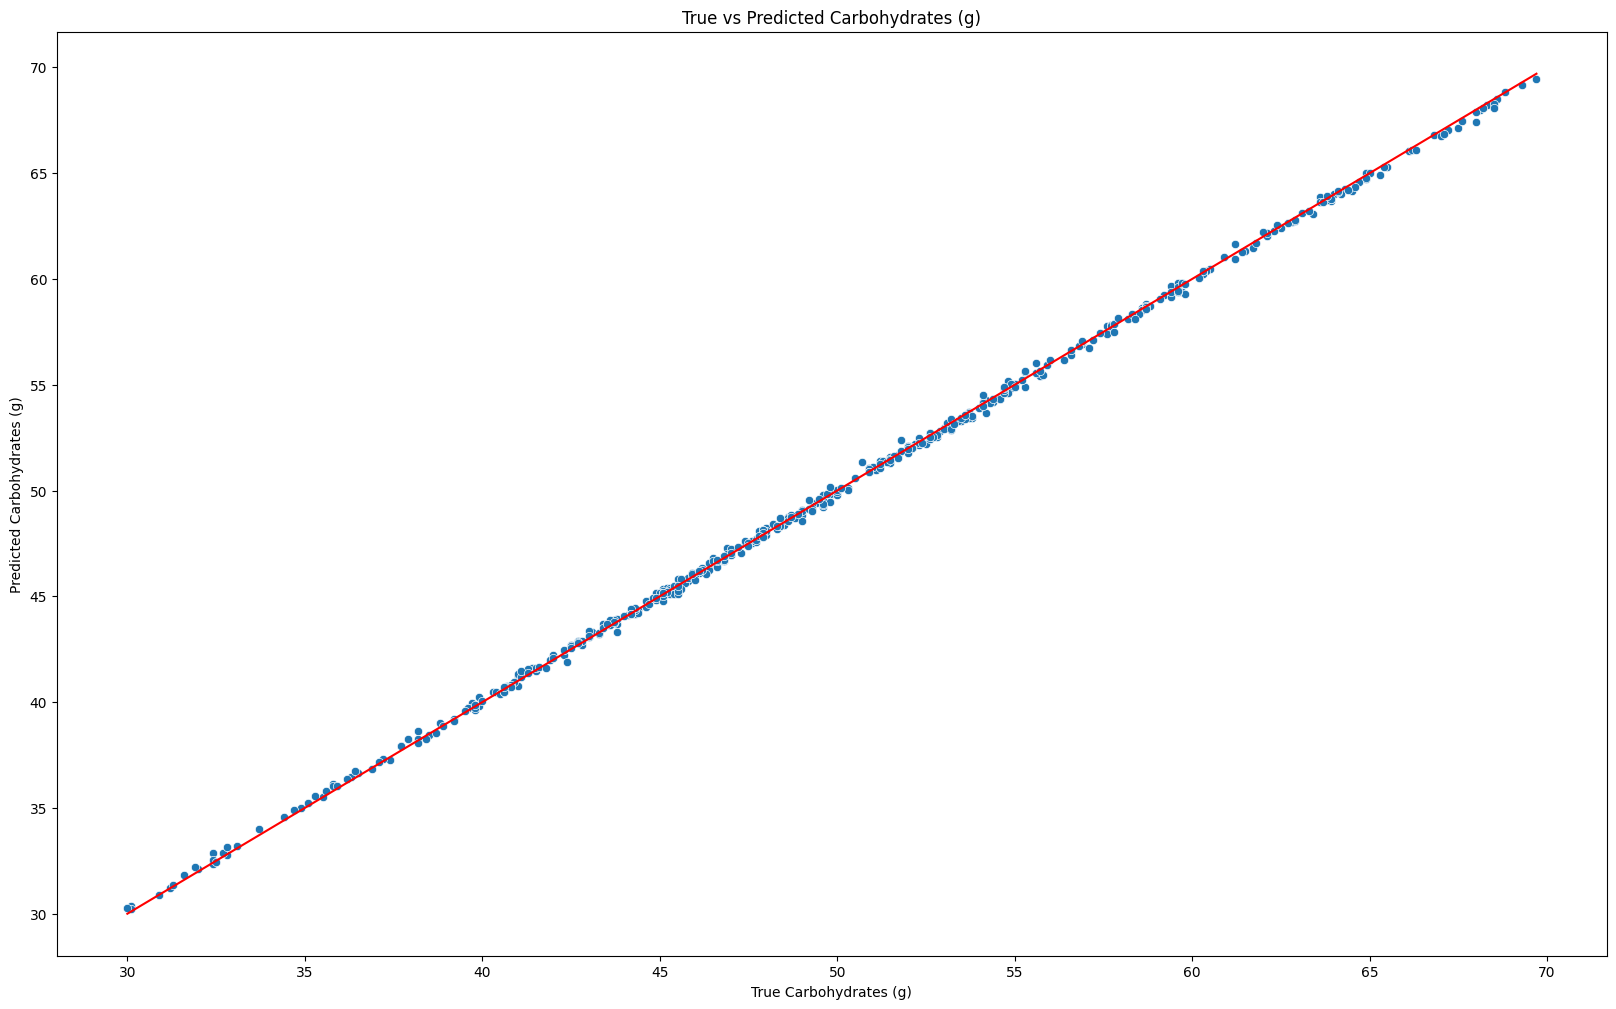

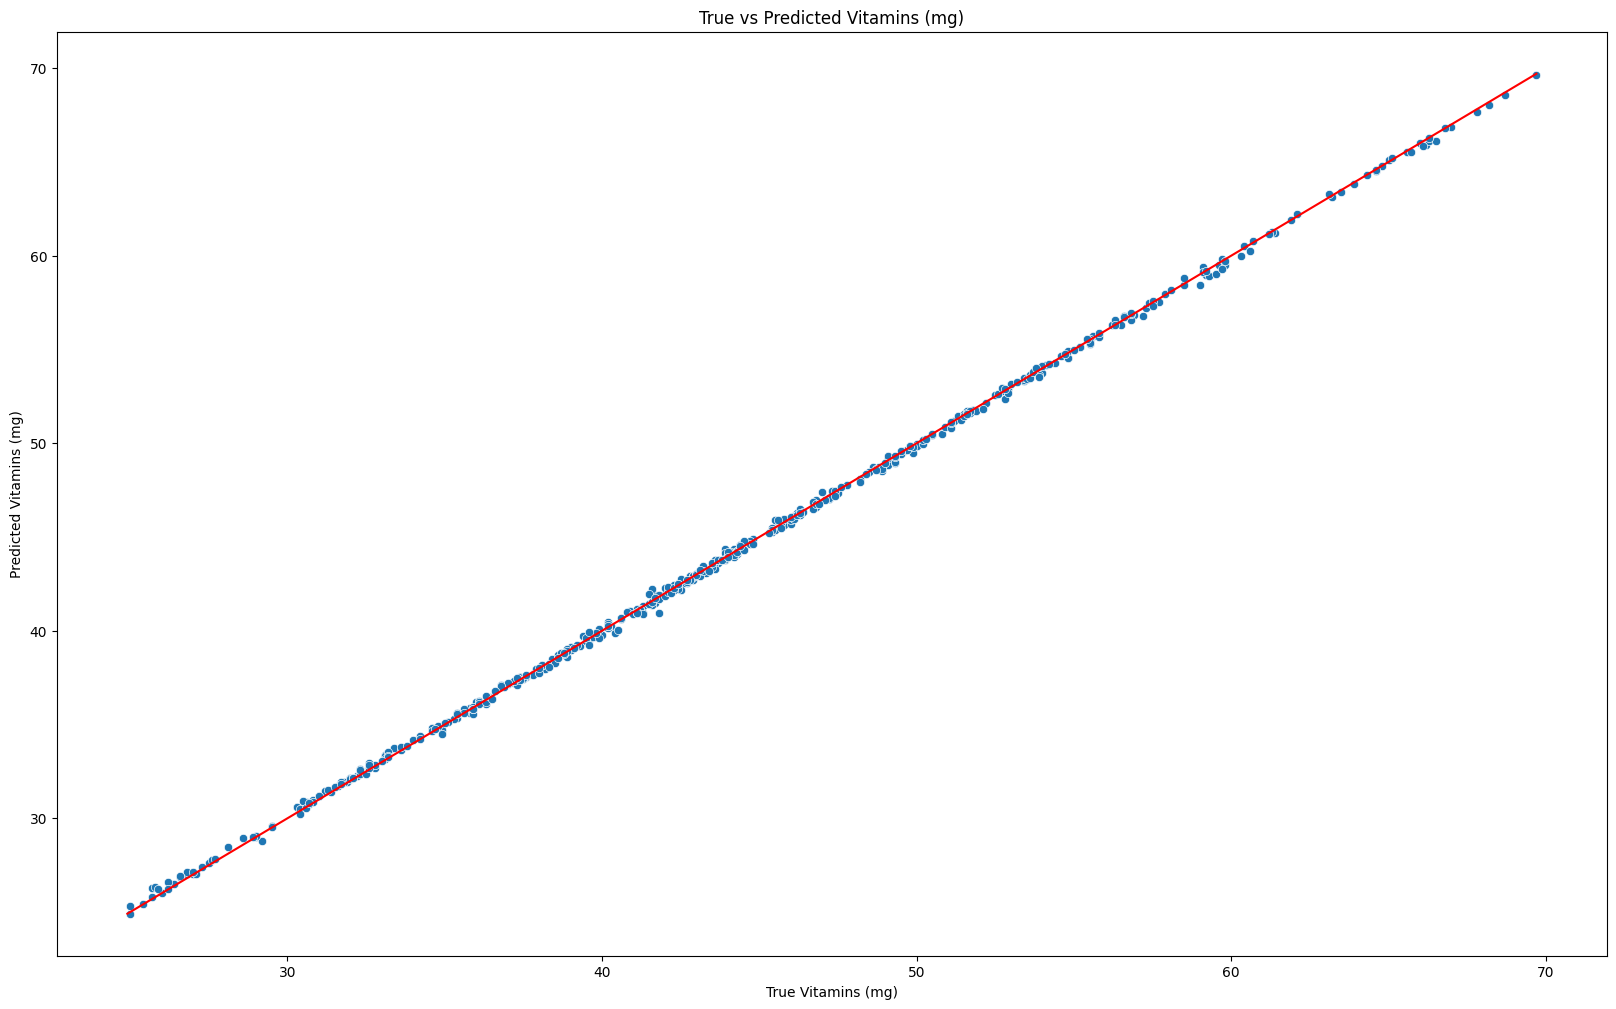

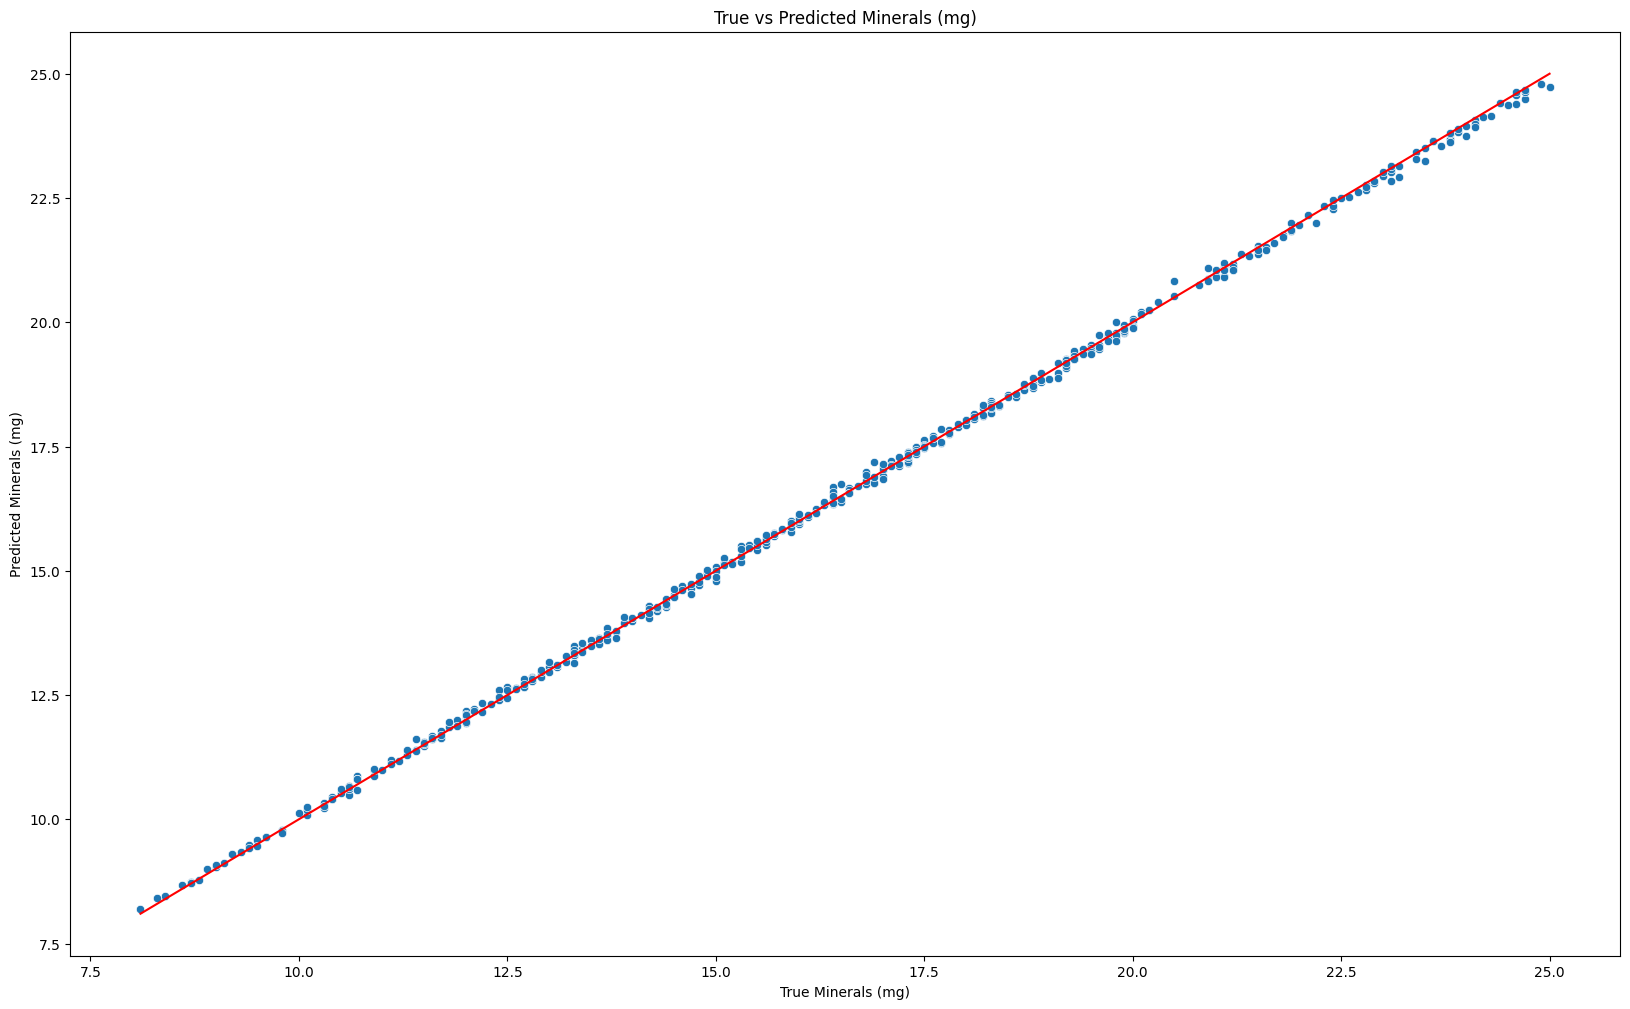

In [ ]:
for col in Y.columns:
    pyplot.figure(figsize=(20, 12))
    sns.scatterplot(x=Y[col], y=P[:, Y.columns.get_loc(col)])
    min_val = min(min(Y[col]), min(P[:, Y.columns.get_loc(col)]))
    max_val = max(max(Y[col]), max(P[:, Y.columns.get_loc(col)]))

    pyplot.plot([min_val, max_val], [min_val, max_val], color='red')
    pyplot.xlabel(f"True {col}")
    pyplot.ylabel(f"Predicted {col}")
    pyplot.title(f"True vs Predicted {col}")

pyplot.show()



In [ ]:
import os, yaml
from llama_index.core.llms import (
                                ChatMessage,
                                MessageRole
                                )
from llama_index.core import Settings, ChatPromptTemplate
from IPython.display import display, Markdown
from llama_index.llms.groq import Groq

c:\Users\pglah\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
with open('artifacts/nutrition_model.pkl', 'rb') as f:
    nutrition_model = pickle.load(f)

with open('secrets.yaml') as f:
    secrets = yaml.load(f, Loader=yaml.FullLoader)

os.environ["GROQ_API_KEY"] = secrets['GROQ_API_KEY']

completion_llm = Groq(
                    model="llama3-70b-8192", 
                    api_key=os.environ["GROQ_API_KEY"],
                    temperature=0.3
                    )
Settings.llm = completion_llm

In [13]:
def inference_nutrition(
                        sample_json,
                        dog_breeds = [
                                'German Shepherd', 'Labrador', 'Pomeranian', 'Rottweiler',
                                'Mutt (Mixed Breed)', 'Golden Retriever', 'Doberman', 'Boxer', 'Dalmatian',
                                'Rhodesian Ridgeback'
                                ],
                        dog_diseases = ['obesity', 'digestive issues', 'healthy', 'diabetes', 'arthritis', 'kidney disease'],
                        output_cols = ['Fat (g)','Protein (g)','Fiber (g)','Carbohydrates (g)','Vitamins (mg)','Minerals (mg)']
                        ):
        sample_df = pd.DataFrame(sample_json, index=[0])
        sample_df['Breed'] = sample_df['Breed'].apply(lambda x: dog_breeds.index(x))
        sample_df['Disease'] = sample_df['Disease'].apply(lambda x: dog_diseases.index(x))

        nutrition = nutrition_model.predict(sample_df)
        
        response = {}
        for i, col in enumerate(output_cols):
                response[col] = round(nutrition[0][i], 2)
        return response

def generate_meal_plan(
                        dog_inputs, nutritions, 
                        vet_recommendations = None,
                        owner_recommendations = None,
                        dog_nutrition_path = 'data/nutrition/dog nutrition.xlsx'
                        ):
        df_nutrition = pd.read_excel(dog_nutrition_path)
        nutrition_json = df_nutrition.to_dict(orient='records')
        nutrition_gen_template = ChatPromptTemplate(
                                                message_templates=[
                                                                ChatMessage(
                                                                        role=MessageRole.SYSTEM, 
                                                                        content="""
                                                                        You are an expert in dog nutrition and have been asked to generate a meal plan for a dog based on below things.
                                                                                        
                                                                                1. **Dog Inputs** : Breed, Age (months), Weight (kg), Disease
                                                                                2. **Recommended Nutritions** : Fat (g), Protein (g), Fiber (g), Carbohydrates (g), Vitamins (mg), Minerals (mg)
                                                                                3. **Food Catelogue** : A list of food items with their nutritional values
                                                                                4. **Vet Recommendations** : Any recommendations from the vet
                                                                                5. **Owner Recommendations** : Any recommendations from the owner

                                                                        You need to generate a meal plan for the dog based on the above inputs. Below you can see all the necessary information.

                                                                        **Dog Inputs** : {dog_inputs}
                                                                        **Recommended Nutritions** : {nutritions}
                                                                        **Food Catelogue** : {nutrition_json}
                                                                        **Vet Recommendations** : {vet_recommendations}
                                                                        **Owner Recommendations** : {owner_recommendations}

                                                                        **Meal Plan** : 
                                                                        """                                     
                                                                        )
                                                                ]
                                                )
        fmt_messages = nutrition_gen_template.format_messages(
                                                        dog_inputs=dog_inputs,
                                                        nutritions=nutritions,
                                                        nutrition_json=nutrition_json,
                                                        vet_recommendations=vet_recommendations,
                                                        owner_recommendations=owner_recommendations
                                                        )
        chat_response = completion_llm.chat(fmt_messages)
        raw_output = chat_response.message.content
        return raw_output

def nutrition_pipeline(
                        dog_inputs,
                        vet_recommendations = None,
                        owner_recommendations = None
                        ):
    nutritions = inference_nutrition(dog_inputs)
    meal_plan = generate_meal_plan(
                                dog_inputs, nutritions,
                                vet_recommendations=vet_recommendations,
                                owner_recommendations=owner_recommendations
                                )
    return meal_plan

In [ ]:
sample_json = {
            "Breed": 'Golden Retriever',
            "Age (months)": 5,
            "Weight (kg)": 22.00,
            "Disease": 'obesity'
            }
vet_recommendations = "Make sure dog eat less sugar"
owner_recommendations = "My dog don't like chicken"

In [ ]:
meal_plan = nutrition_pipeline(
                                sample_json,
                                vet_recommendations=vet_recommendations,
                                owner_recommendations=owner_recommendations
                                )
display(Markdown(meal_plan))

Based on the provided inputs, I will generate a meal plan for the dog.

**Dog Inputs:**

* Breed: Golden Retriever
* Age: 5 months
* Weight: 17.2 kg
* Disease: Obesity

**Recommended Nutritions:**

* Fat: 8.11 g
* Protein: 18.57 g
* Fiber: 11.94 g
* Carbohydrates: 55.96 g
* Vitamins: 33.2 mg
* Minerals: 16.87 mg

**Food Catalogue:**

The food catalogue provides a list of foods with their nutritional values. I will use this catalogue to create a meal plan that meets the recommended nutritional requirements.

**Vet Recommendations:**

* Make sure the dog eats less sugar

**Owner Recommendations:**

* The dog does not like chicken

**Meal Plan:**

To create a meal plan, I will select foods from the catalogue that meet the recommended nutritional requirements and avoid chicken. I will also ensure that the meal plan is low in sugar.

Here is a sample meal plan:

**Breakfast:**

* 1 cup Cooked Oatmeal (2.5 kcal, 1.4 g protein, 12 g fat, 1.7 g carbohydrates, 0 g fiber)
* 1/2 cup Cooked Sweet Potatoes (1.6 kcal, 0.1 g protein, 20 g fat, 3 g carbohydrates, 14187 g fiber)
* 1/4 cup Green Beans (1.8 kcal, 0.1 g protein, 7 g fat, 2.7 g carbohydrates, 0 g fiber)

Total: 5.9 kcal, 2.6 g protein, 39 g fat, 7.4 g carbohydrates, 14187 g fiber

**Lunch:**

* 1 cup Cooked Quinoa (4.1 kcal, 1.9 g protein, 21 g fat, 2.8 g carbohydrates, 14 g fiber)
* 1/2 cup Cooked Lentils (9 kcal, 0.4 g protein, 20 g fat, 7.9 g carbohydrates, 0 g fiber)
* 1/4 cup Carrots (0.9 kcal, 0.2 g protein, 10 g fat, 2.8 g carbohydrates, 16706 g fiber)

Total: 14 kcal, 2.5 g protein, 51 g fat, 13.5 g carbohydrates, 16720 g fiber

**Dinner:**

* 1 cup Cooked Salmon (22 kcal, 13 g protein, 0 g fat, 0 g carbohydrates, 0 g fiber)
* 1/2 cup Cooked Broccoli (3.7 kcal, 0.6 g protein, 11 g fat, 3.3 g carbohydrates, 567 g fiber)
* 1/4 cup Apples (0.3 kcal, 0.2 g protein, 14 g fat, 2.4 g carbohydrates, 54 g fiber)

Total: 26 kcal, 14.8 g protein, 25 g fat, 5.7 g carbohydrates, 621 g fiber

**Snacks:**

* 1/2 cup Cottage Cheese (11 kcal, 4.3 g protein, 3.4 g fat, 0 g carbohydrates, 0 g fiber)
* 1/2 cup Pineapple (0.5 kcal, 0.1 g protein, 13 g fat, 1.4 g carbohydrates, 58 g fiber)

Total: 11.5 kcal, 4.4 g protein, 16.4 g fat, 1.4 g carbohydrates, 58 g fiber

This meal plan provides a balanced diet that meets the recommended nutritional requirements and avoids chicken. It is also low in sugar and includes a variety of fruits and vegetables to provide essential vitamins and minerals.